In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# import data

In [3]:
from emissions.data import load_data, clean_data, split
df = load_data()
df = clean_data(df)
df.head()

----------------start loading data----------------
Data loaded: 187503 records
----------------start cleaning data----------------

Records in input data: 187503

Share of Pass and Fail before cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10813
Unique vehicles in Pass: 84908

Records where vehicles received tests more than 1 time in a day: 9602

Records after keeping one test per day: 183457

Records where ODOMETER = 0: 875

Records after droping rows where ODOMETER is missing: 182487

Records after droping rows where MILE_YEAR > 40,000: 181445

Records with missing GVWR: 7960

Records after droping rows where GVWR is super low or missing: 173480

61 make labels each account for less than 0.01% of cars and together account for 0.1009% of cars
Grouping these car makes into one category called 'other'

Records in output data:173480

Share of Pass and Fail after cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10289
Unique vehicles in Pass: 80064


,VEHICLE_TYPE,VEHICLE_AGE,MILE_YEAR,GVWR,ENGINE_SIZE,TRANS_TYPE,TEST_TYPE,RESULT,MAKE,BEFORE_2000,ENGINE_WEIGHT_RATIO,MAKE_VEHICLE_TYPE
0,1,29,7419.34,2625.0,1600,A,I,1,other,1,0.61,other1
1,1,14,11206.29,3000.0,2300,A,I,0,other,0,0.77,other1
2,4,14,8873.36,4250.0,3400,A,I,0,toyota,0,0.80,toyota4
3,3,13,5101.15,6000.0,5700,A,I,0,dodge,0,0.95,dodge3
4,1,9,12496.78,3375.0,2500,A,I,0,nissan,0,0.74,nissan1


# check the features first

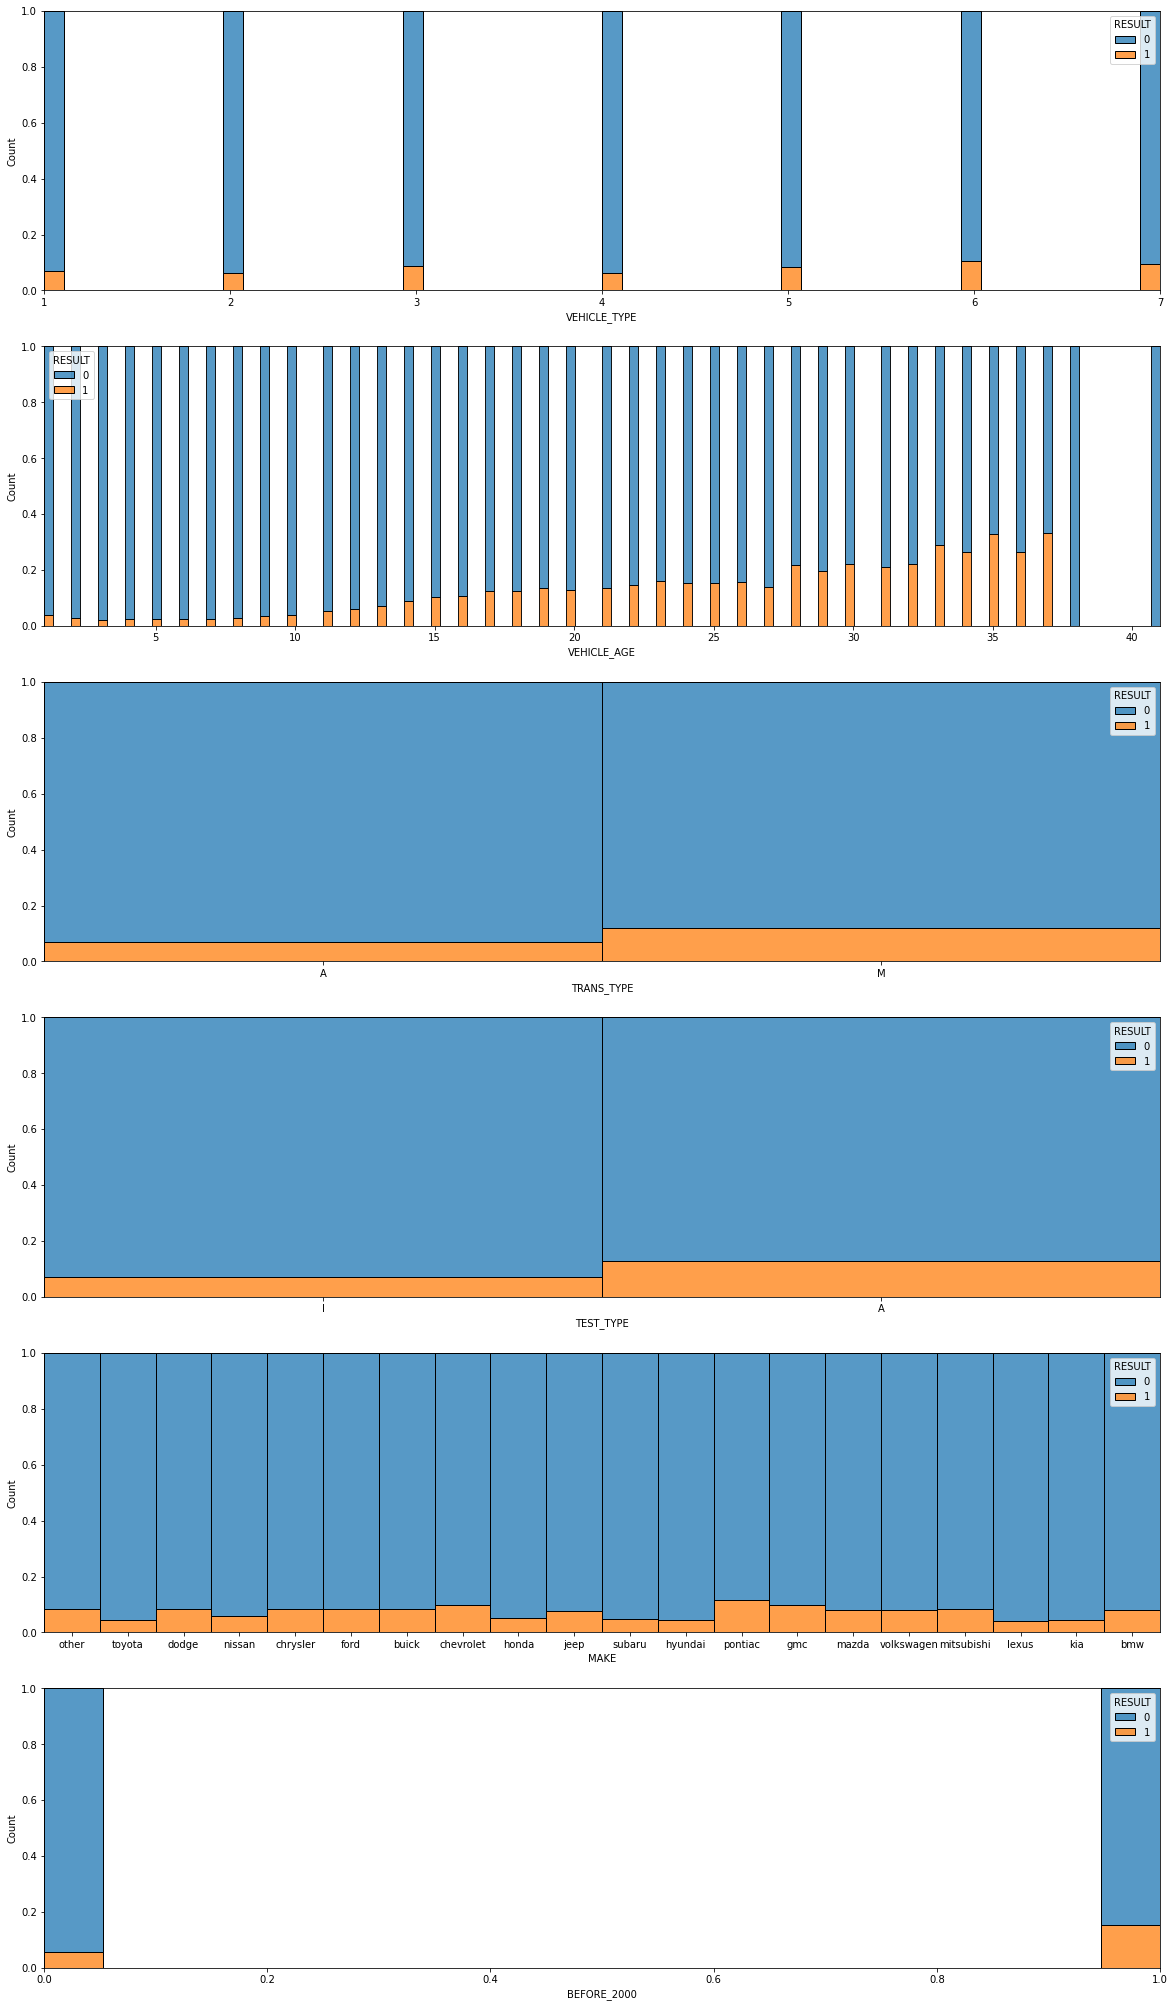

In [4]:
# categorical columns
cols = ['VEHICLE_TYPE', 'VEHICLE_AGE', 'TRANS_TYPE', 'TEST_TYPE', 'MAKE', 'BEFORE_2000']
fig, axs = plt.subplots(6, 1, figsize=(20, 36))
for col, ax in zip(cols, axs.flat):
    sns.histplot(data=df, x=col, hue='RESULT', multiple='fill', ax=ax)

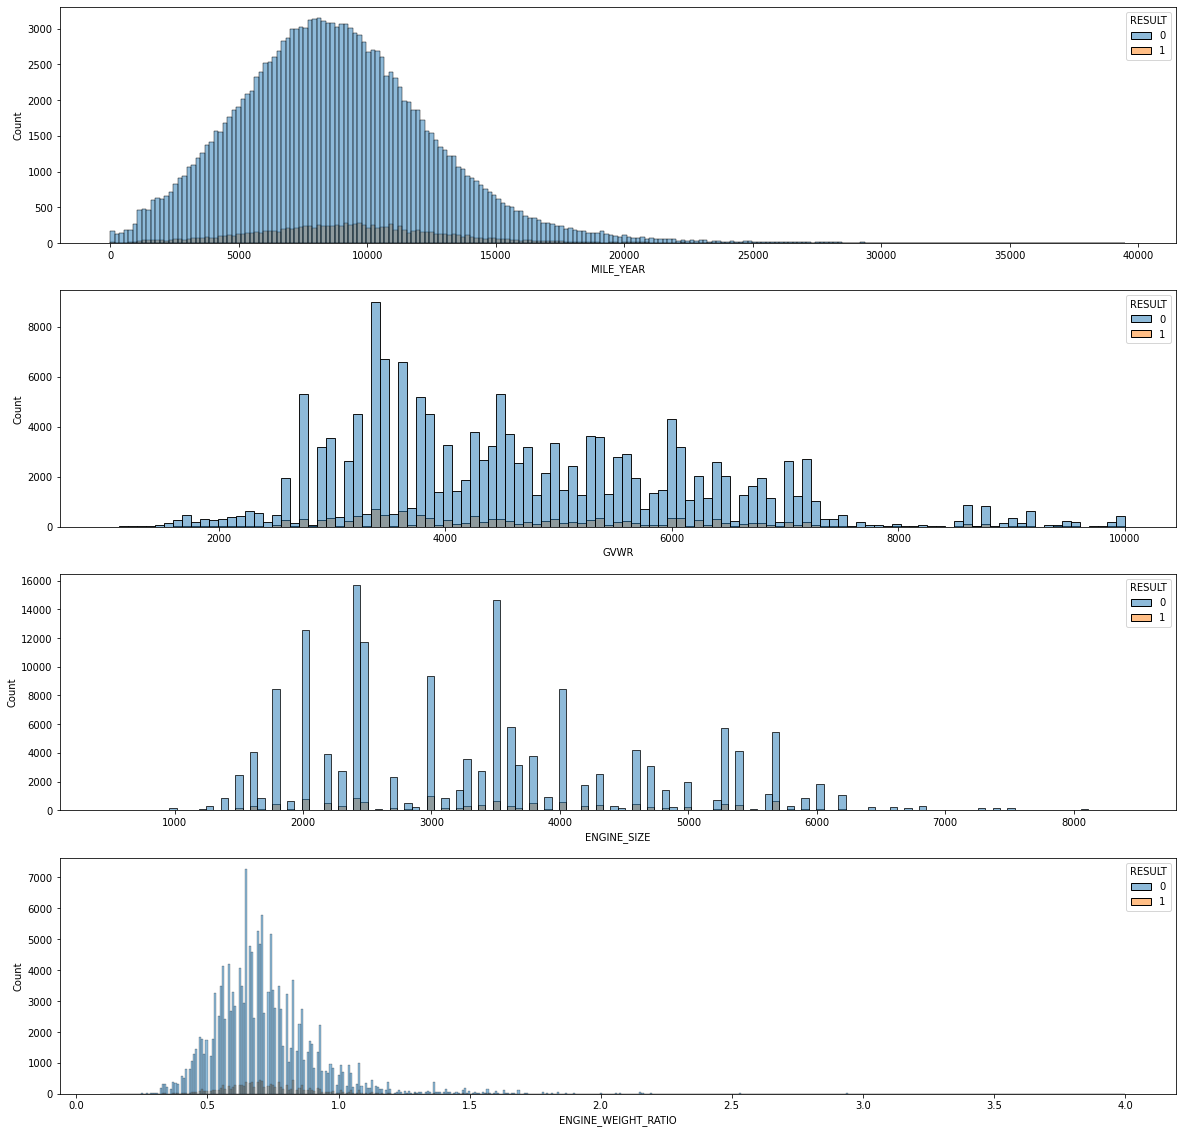

In [5]:
# numerical columns
cols = ['MILE_YEAR', 'GVWR', 'ENGINE_SIZE', 'ENGINE_WEIGHT_RATIO']
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
for col, ax in zip(cols, axs.flat):
    sns.histplot(data=df, x=col, hue='RESULT', ax=ax)

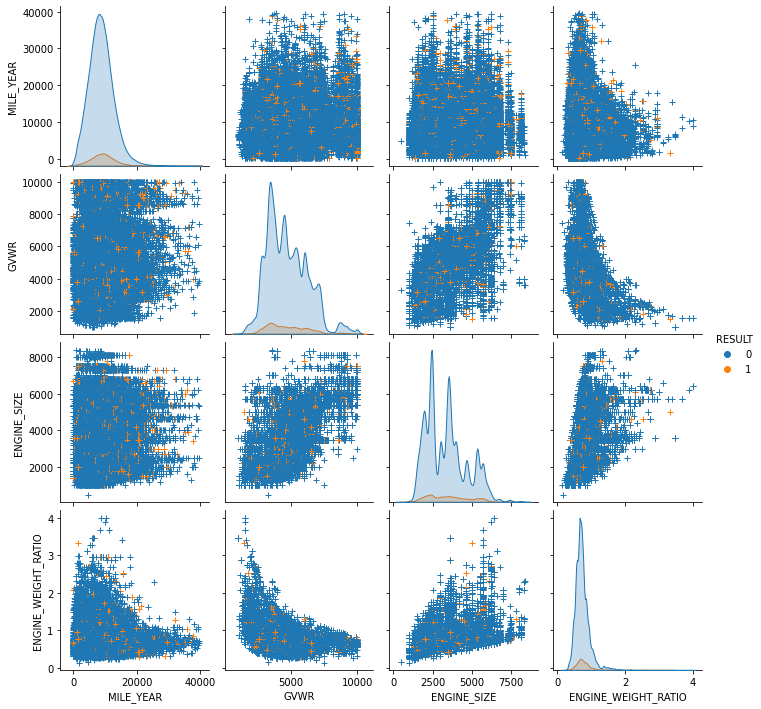

In [6]:
# numerical columns
cols = ['MILE_YEAR', 'GVWR', 'ENGINE_SIZE', 'ENGINE_WEIGHT_RATIO', 'RESULT']
sns.pairplot(data=df[cols], 
             hue='RESULT',
             plot_kws=dict(marker="+", linewidth=1, edgecolor=None));

# Train test split

In [7]:
X_train, X_test, y_train, y_test = split(df)

----------------data splitted into train test----------------
Share of Pass and Fail in train set:
Pass: 7%
Fail: 93%
Share of Pass and Fail in test set:
Pass: 7%
Fail: 93%


# Baseline model 1:  all vehicles with age > 16 will fail the test
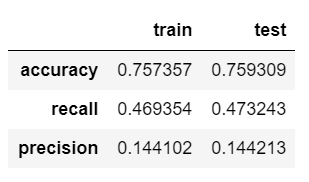

In [8]:
X_train.join(y_train).groupby('RESULT').VEHICLE_AGE.describe()

,count,mean,std,min,25%,50%,75%,max
RESULT,,,,,,,,
0,128636.0,11.967350,6.196160,1.0,7.0,11.0,16.0,41.0
1,10148.0,16.404809,6.556928,1.0,12.0,16.0,20.0,37.0


# Baseline model 2: VEHICLE_AGE + MILE_YEAR
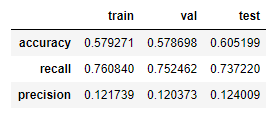
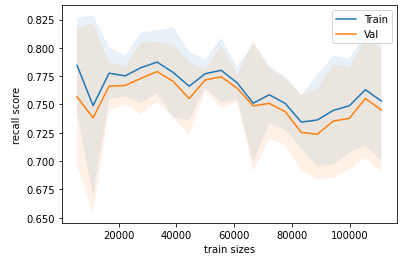


In [16]:
cols = ['VEHICLE_AGE', 'MILE_YEAR']
X_train[cols].head()

,VEHICLE_AGE,MILE_YEAR
67826,7,8751.29
157430,10,6292.80
32561,18,12250.00
114635,19,7523.21
12560,21,7611.10


## grid search


In [18]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=5,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 3}, 0.7524615246414672)

In [19]:
result = search.cv_results_
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][1], 
                       'recall': result['mean_train_recall'][1],
                       'precision': result['mean_train_precision'][1]}, 
              'val':{'accuracy': result['mean_test_accuracy'][1], 
                       'recall': result['mean_test_recall'][1],
                       'precision': result['mean_test_precision'][1]}
             })
tmp

,train,val
accuracy,0.579271,0.578698
recall,0.760840,0.752462
precision,0.121739,0.120373


## scoring on test set

In [20]:
y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp

,train,val,test
accuracy,0.579271,0.578698,0.605199
recall,0.760840,0.752462,0.737220
precision,0.121739,0.120373,0.124009


## learning curve


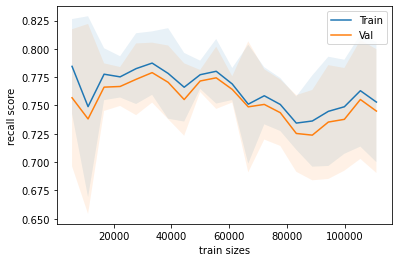

In [21]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        cv=cv,
                                                        scoring='recall',
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes');

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

scores = {'train':{}, 'test':{}}
# train set
y_true = y_train
y_pred = (X_train.VEHICLE_AGE > 16).astype('int')
scores['train']['accuracy'] = accuracy_score(y_true, y_pred)
scores['train']['recall'] = recall_score(y_true, y_pred)
scores['train']['precision'] = precision_score(y_true, y_pred)
# test set
y_true = y_test
y_pred = (X_test.VEHICLE_AGE > 16).astype('int')
scores['test']['accuracy'] = accuracy_score(y_true, y_pred)
scores['test']['recall'] = recall_score(y_true, y_pred)
scores['test']['precision'] = precision_score(y_true, y_pred)

pd.DataFrame(scores)

,train,test
accuracy,0.757357,0.759309
recall,0.469354,0.473243
precision,0.144102,0.144213


# Evaluate features

## model 3: VEHICLE_AGE + TRANS_TYPE
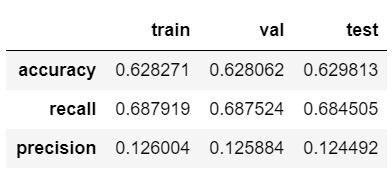
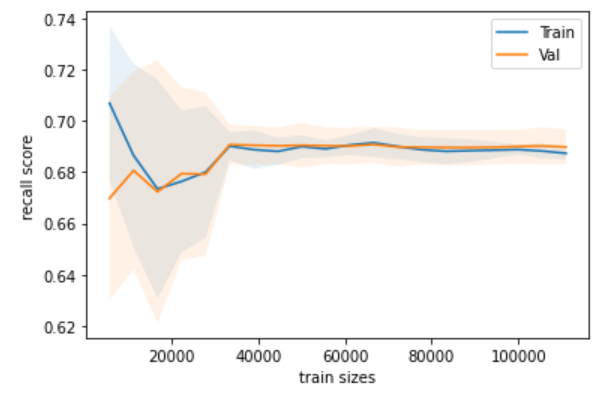


In [10]:
cols = ['VEHICLE_AGE', 'TRANS_TYPE'] 
X_train[cols].head()

,VEHICLE_AGE,TRANS_TYPE
67826,7,A
157430,10,A
32561,18,A
114635,19,A
12560,21,A


In [12]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['TRANS_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=5,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 5}, 0.687523665471355)

In [14]:
result = search.cv_results_
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][3], 
                       'recall': result['mean_train_recall'][3],
                       'precision': result['mean_train_precision'][3]}, 
              'val':{'accuracy': result['mean_test_accuracy'][3], 
                       'recall': result['mean_test_recall'][3],
                       'precision': result['mean_test_precision'][3]}
             })

y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp

,train,val,test
accuracy,0.628271,0.628062,0.629813
recall,0.687919,0.687524,0.684505
precision,0.126004,0.125884,0.124492


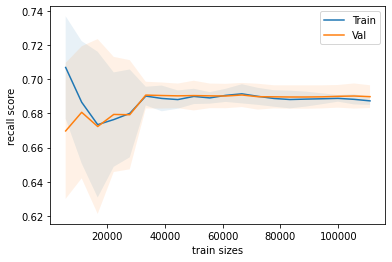

In [15]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        cv=cv,
                                                        scoring='recall',
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes');

## Model 4: VEHICLE_AGE + MAKE
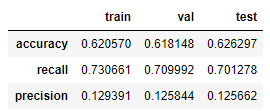
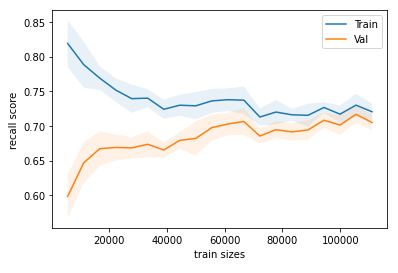


In [22]:
cols = ['VEHICLE_AGE', 'MAKE']
X_train[cols].head()

,VEHICLE_AGE,MAKE
67826,7,nissan
157430,10,toyota
32561,18,ford
114635,19,toyota
12560,21,ford


In [24]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=5,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 16}, 0.709893247419802)

In [25]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head(5)

,param_model__max_depth,mean_test_recall,mean_train_recall
14,16,0.709893,0.730661
15,17,0.708908,0.730316
17,19,0.708614,0.732336
16,18,0.707333,0.730094
11,13,0.704475,0.719353


In [27]:
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][14], 
                       'recall': result['mean_train_recall'][14],
                       'precision': result['mean_train_precision'][14]}, 
              'val':{'accuracy': result['mean_test_accuracy'][14], 
                       'recall': result['mean_test_recall'][14],
                       'precision': result['mean_test_precision'][14]}
             })

y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp

,train,val,test
accuracy,0.620570,0.618148,0.626297
recall,0.730661,0.709893,0.701278
precision,0.129391,0.125830,0.125662


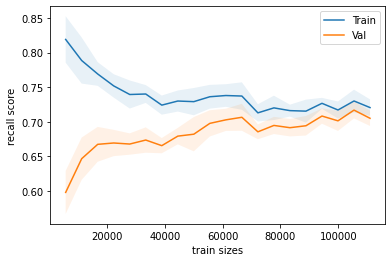

In [28]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        cv=cv,
                                                        scoring='recall',
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes');

## Model 5: VEHICLE_AGE + VEHICLE_TYPE
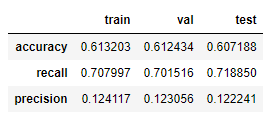
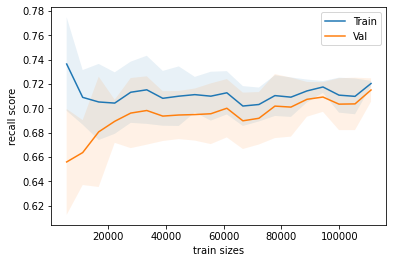


In [29]:
cols = ['VEHICLE_AGE', 'VEHICLE_TYPE']
X_train[cols].head()

,VEHICLE_AGE,VEHICLE_TYPE
67826,7,1
157430,10,1
32561,18,3
114635,19,1
12560,21,1


In [30]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['VEHICLE_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(2, 20, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=5,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 7}, 0.7015157069778846)

In [32]:
result = search.cv_results_
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][5], 
                       'recall': result['mean_train_recall'][5],
                       'precision': result['mean_train_precision'][5]}, 
              'val':{'accuracy': result['mean_test_accuracy'][5], 
                       'recall': result['mean_test_recall'][5],
                       'precision': result['mean_test_precision'][5]}
             })

y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp


,train,val,test
accuracy,0.613203,0.612434,0.607188
recall,0.707997,0.701516,0.718850
precision,0.124117,0.123056,0.122241


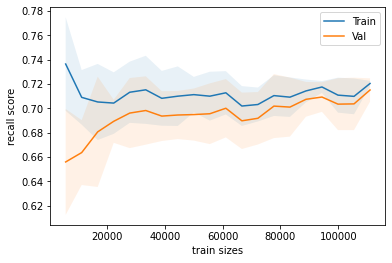

In [33]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        cv=cv,
                                                        scoring='recall',
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes');

## Model 6: VEHICLE_AGE + MAKE_VEHICLE_TYPE
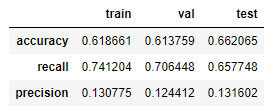
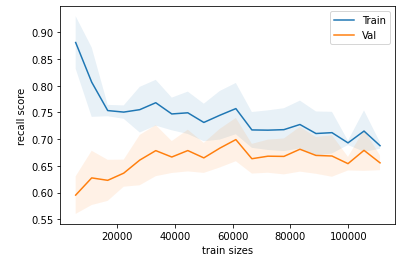


In [34]:
cols = ['VEHICLE_AGE', 'MAKE_VEHICLE_TYPE']
X_train[cols].head()

,VEHICLE_AGE,MAKE_VEHICLE_TYPE
67826,7,nissan1
157430,10,toyota1
32561,18,ford3
114635,19,toyota1
12560,21,ford1


In [44]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['MAKE_VEHICLE_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(14, 34, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=5,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 21}, 0.7064483705482328)

In [49]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_model__max_depth,mean_test_recall,mean_train_recall
7,21,0.706448,0.741204
8,22,0.705069,0.741746
9,23,0.703097,0.741475
10,24,0.700929,0.740736
11,25,0.698860,0.740243


In [47]:
## result = search.cv_results_
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][7], 
                       'recall': result['mean_train_recall'][7],
                       'precision': result['mean_train_precision'][7]}, 
              'val':{'accuracy': result['mean_test_accuracy'][7], 
                       'recall': result['mean_test_recall'][7],
                       'precision': result['mean_test_precision'][7]}
             })

y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp


,train,val,test
accuracy,0.618661,0.613759,0.662065
recall,0.741204,0.706448,0.657748
precision,0.130775,0.124412,0.131602


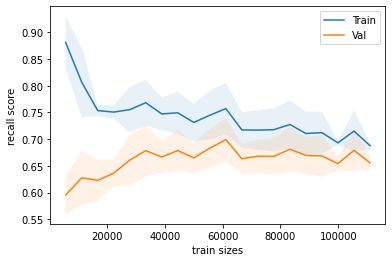

In [52]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        scoring='recall',
                                                        cv=cv,
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes');

## Model 7: VEHICLE_AGE + ENGINE_WEIGHT_RATIO
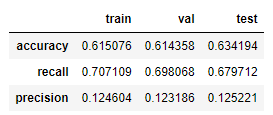
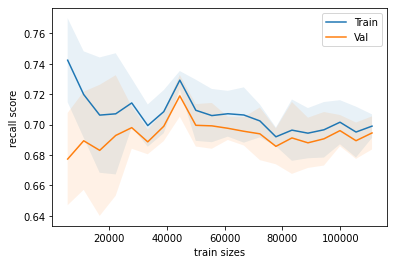

In [54]:
cols = ['VEHICLE_AGE', 'ENGINE_WEIGHT_RATIO']
X_train[cols].head()

,VEHICLE_AGE,ENGINE_WEIGHT_RATIO
67826,7,0.74
157430,10,0.69
32561,18,0.60
114635,19,0.65
12560,21,0.98


In [63]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(3, 15, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=5,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 5}, 0.6980684508129656)

In [64]:
result = search.cv_results_
pd.DataFrame(result)[['param_max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()


,param_max_depth,mean_test_recall,mean_train_recall
2,5,0.698068,0.707109
3,6,0.697772,0.709007
4,7,0.695113,0.711766
5,8,0.690777,0.716964
6,9,0.687130,0.720684


In [65]:
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][2], 
                       'recall': result['mean_train_recall'][2],
                       'precision': result['mean_train_precision'][2]}, 
              'val':{'accuracy': result['mean_test_accuracy'][2], 
                       'recall': result['mean_test_recall'][2],
                       'precision': result['mean_test_precision'][2]}
             })

y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp

,train,val,test
accuracy,0.615076,0.614358,0.634194
recall,0.707109,0.698068,0.679712
precision,0.124604,0.123186,0.125221


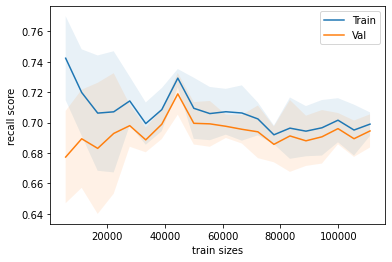

In [66]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        scoring='recall',
                                                        cv=cv,
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes');

## Model 8: VEHICLE_AGE + ENGINE_SIZE
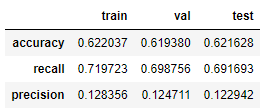
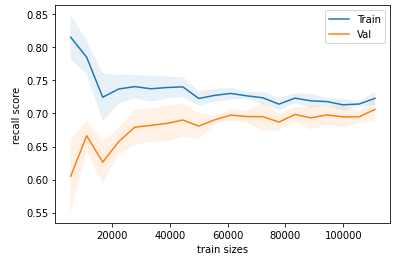


In [68]:
cols = ['VEHICLE_AGE', 'ENGINE_SIZE']
X_train[cols].head()

,VEHICLE_AGE,ENGINE_SIZE
67826,7,2500
157430,10,2400
32561,18,3000
114635,19,2200
12560,21,3800


In [72]:
tree = DecisionTreeClassifier(class_weight='balanced')

# Hyperparameter Grid
grid = {'max_depth': np.arange(3, 15, 1)}

# Instanciate Grid Search
search = GridSearchCV(tree, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=5,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'max_depth': 9}, 0.698755872363051)

In [73]:
result = search.cv_results_
pd.DataFrame(result)[['param_max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_max_depth,mean_test_recall,mean_train_recall
6,9,0.698756,0.719723
7,10,0.691957,0.719847
4,7,0.689792,0.705828
5,8,0.689100,0.704942
3,6,0.687917,0.699719


In [74]:
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][6], 
                       'recall': result['mean_train_recall'][6],
                       'precision': result['mean_train_precision'][6]}, 
              'val':{'accuracy': result['mean_test_accuracy'][6], 
                       'recall': result['mean_test_recall'][6],
                       'precision': result['mean_test_precision'][6]}
             })

y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp

,train,val,test
accuracy,0.622037,0.619380,0.621628
recall,0.719723,0.698756,0.691693
precision,0.128356,0.124711,0.122942


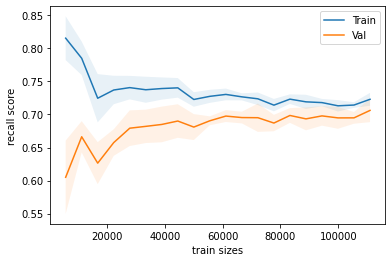

In [75]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        scoring='recall',
                                                        cv=cv,
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes');

## Model 9: VEHICLE_AGE + TEST_TYPE
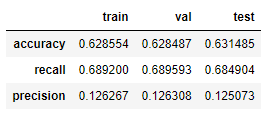
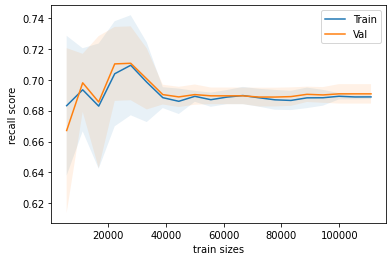


In [76]:
cols = ['VEHICLE_AGE', 'TEST_TYPE']
X_train[cols].head()

,VEHICLE_AGE,TEST_TYPE
67826,7,I
157430,10,I
32561,18,I
114635,19,I
12560,21,I


In [81]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), ['TEST_TYPE'])],
    remainder='passthrough'
)

# Combine preprocessor and linear model in pipeline
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Hyperparameter Grid
grid = {'model__max_depth': np.arange(3, 10, 1)}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      grid, 
                      scoring=['accuracy', 'recall', 'precision'],
                      cv=5,
                      refit='recall',
                      return_train_score=True,
                      n_jobs=-1
                     ) 
search.fit(X_train[cols], y_train)

search.best_params_, search.best_score_

({'model__max_depth': 3}, 0.6895929223306392)

In [82]:
result = search.cv_results_
pd.DataFrame(result)[['param_model__max_depth', 
                      'mean_test_recall', 
                      'mean_train_recall']].sort_values('mean_test_recall', ascending=False).head()

,param_model__max_depth,mean_test_recall,mean_train_recall
0,3,0.689593,0.689200
2,5,0.689298,0.689766
1,4,0.689002,0.689249
4,7,0.688214,0.689545
3,6,0.688115,0.689471


In [83]:
tmp = pd.DataFrame({'train':{'accuracy': result['mean_train_accuracy'][0], 
                       'recall': result['mean_train_recall'][0],
                       'precision': result['mean_train_precision'][0]}, 
              'val':{'accuracy': result['mean_test_accuracy'][0], 
                       'recall': result['mean_test_recall'][0],
                       'precision': result['mean_test_precision'][0]}
             })

y_pred = search.best_estimator_.predict(X_test[cols])
y_true = y_test
tmp.loc['accuracy', 'test'] = accuracy_score(y_true, y_pred)
tmp.loc['recall', 'test'] = recall_score(y_true, y_pred)
tmp.loc['precision', 'test'] = precision_score(y_true, y_pred)
tmp

,train,val,test
accuracy,0.628554,0.628487,0.631485
recall,0.689200,0.689593,0.684904
precision,0.126267,0.126308,0.125073


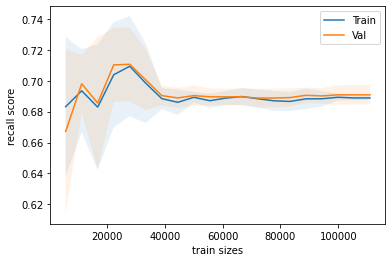

In [84]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(search.best_estimator_, 
                                                        X_train[cols], 
                                                        y_train, 
                                                        train_sizes=np.linspace(0.05, 1, 20),
                                                        scoring='recall',
                                                        cv=cv,
                                                        n_jobs=-1
                                                       )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, test_scores_mean, label = 'Val')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1)
plt.legend()
plt.ylabel('recall score')
plt.xlabel('train sizes');


# Baseline model 2 + 